In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as XGB
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import shap

In [5]:
df = pd.read_csv('data.csv')

In [6]:
df = df.drop('id', axis=1)

In [7]:
null_counts = df.isnull().sum()
if null_counts.sum() > 0:
  print(null_counts[null_counts > 0])
else:
  print("No features with null values found.")

No features with null values found.


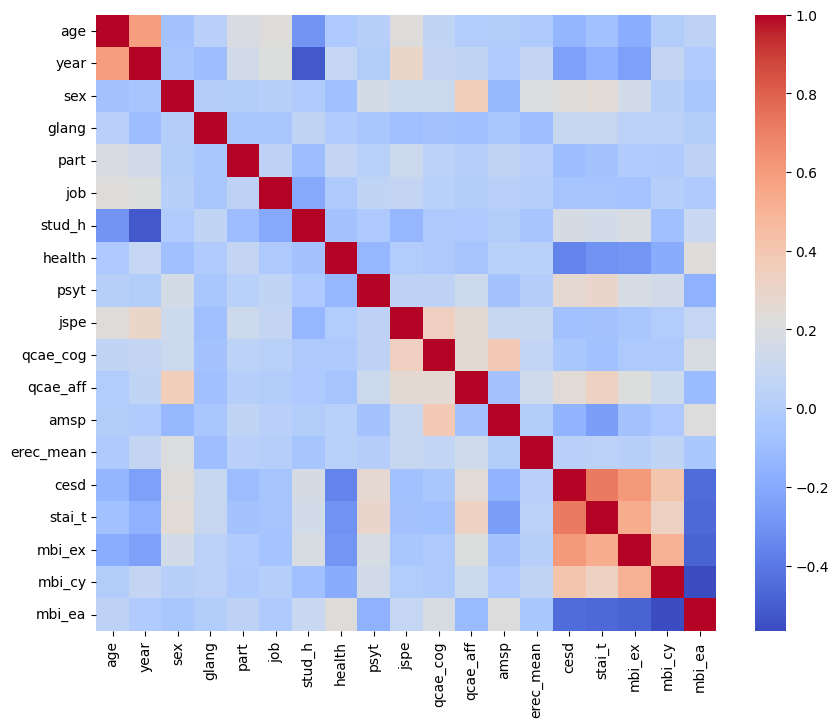

In [8]:
# Calculate the correlation matrix
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.show()

##**Regression**


In [9]:
X_train_reg,X_test_reg,y_train_reg, y_test_reg = train_test_split(df.drop(['stai_t'], axis=1), df['stai_t'], test_size=0.1, random_state=42)

In [10]:
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
# Initialize lists to store the performance metrics and predictions for each model
model_names = ['XGBoost', 'Gradient Boosting', 'Linear Regression', 'KNN']
models = [
    XGBRegressor(learning_rate=0.1, n_estimators=300, max_depth=5, random_state=101),
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    LinearRegression(),
    KNeighborsRegressor(n_neighbors=5)
]

In [11]:
results = {}
for model_name, model in zip(model_names, models):
    print(f"training and testing {model_name}")
    mse_sum = 0
    r2_sum = 0

    for train_index, test_index in kf.split(X_train_reg):
        # Split and scale the data
        X_train_fold_reg, X_valid_reg = X_train_reg.iloc[train_index], X_train_reg.iloc[test_index]
        y_train_fold_reg, y_valid_reg = y_train_reg.iloc[train_index], y_train_reg.iloc[test_index]

        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold_reg)
        X_valid_scaled = scaler.transform(X_valid_reg)

        # Fit the model
        model.fit(X_train_scaled, y_train_fold_reg)

        # Make predictions and calculate metrics
        y_pred_reg = model.predict(X_valid_scaled)
        mse_sum += mean_squared_error(y_valid_reg, y_pred_reg)
        r2_sum += r2_score(y_valid_reg, y_pred_reg)

    # Store results for this model
    results[model_name] = {
        'MSE Scores': mse_sum / k,
        'R2 Scores': r2_sum / k
    }

training and testing XGBoost
training and testing Gradient Boosting
training and testing Linear Regression
training and testing KNN


In [12]:
results_df = pd.DataFrame(results)

results_df = results_df.T.rename(
    columns={
        "MSE Scores": "MSE Scores",
        "R2 Scores": "R2 Scores"
    }
)

print(results_df)

                   MSE Scores  R2 Scores
XGBoost             71.614081   0.488185
Gradient Boosting   65.011310   0.536790
Linear Regression   70.409122   0.497101
KNN                 59.310633   0.576580


##**Classification**

In [13]:
# Convert 'stai_t' to categorical variable
def categorize_stai(score):
    if score <= 37:
        return 'low'
    elif score <= 44:
        return 'medium'
    else:
        return 'high'

df['stai_category'] = df['stai_t'].apply(categorize_stai)

In [14]:
# Split data into features and target variable
X_classifier = df.drop(['stai_t', 'stai_category'], axis=1)
y_classifier = df['stai_category']

# Split data into training and testing sets
X_train_classifier, X_test_classifier, y_train_classifier, y_test_classifier = train_test_split(X_classifier, y_classifier, test_size=0.1, random_state=42)

In [15]:
# Define the models and their names
model_names = ['XGBoost', 'Gradient Boosting', 'KNN']
models = [
    XGBClassifier(learning_rate=0.1, n_estimators=300, max_depth=5, random_state=101),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    KNeighborsClassifier(n_neighbors=5)
]


In [16]:
# Perform k-fold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

results = {}
for model_name, model in zip(model_names, models):
    print(f"Training and testing {model_name}")
    accuracy_sum = 0
    precision_sum = 0
    recall_sum = 0
    f1_sum = 0

    for train_index, test_index in kf.split(X_train_classifier):
        # Split the data for this fold
        X_train_fold_classifier, X_valid_classifier = X_train_classifier.iloc[train_index], X_train_classifier.iloc[test_index]
        y_train_fold_classifier, y_valid_classifier = y_train_classifier.iloc[train_index], y_train_classifier.iloc[test_index]

        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled_classifier = scaler.fit_transform(X_train_fold_classifier)
        X_valid_scaled_classifier = scaler.transform(X_valid_classifier)

        # Encode categorical labels to numerical values
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train_fold_classifier)

        # Fit the model using encoded labels
        model.fit(X_train_scaled_classifier, y_train_encoded)

        # Make predictions and calculate metrics
        y_pred_classifier = model.predict(X_valid_scaled_classifier)

        # Decode numerical predictions back to categorical labels
        y_pred_decoded_classifier = le.inverse_transform(y_pred_classifier)


        accuracy_sum += accuracy_score(y_valid_classifier, y_pred_decoded_classifier)
        precision_sum += precision_score(y_valid_classifier, y_pred_decoded_classifier, average='weighted', zero_division=0)
        recall_sum += recall_score(y_valid_classifier, y_pred_decoded_classifier, average='weighted')
        f1_sum += f1_score(y_valid_classifier, y_pred_decoded_classifier, average='weighted')

    # Calculate average metrics for this model
    results[model_name] = {
        'Accuracy': accuracy_sum / k,
        'Precision': precision_sum / k,
        'Recall': recall_sum / k,
        'F1-Score': f1_sum / k
    }

Training and testing XGBoost
Training and testing Gradient Boosting
Training and testing KNN


In [17]:
results_df = pd.DataFrame(results)

results_df = results_df.T.rename(
    columns={
        "Accuracy": "Accuracy",
        "Precision": "Precision",
        "Recall": "Recall",
        "F1-Score": "F1-Score",
    }
)

print(results_df)

                   Accuracy  Precision    Recall  F1-Score
XGBoost            0.652563   0.636463  0.652563  0.637351
Gradient Boosting  0.644968   0.628652  0.644968  0.628125
KNN                0.588402   0.563824  0.588402  0.563122


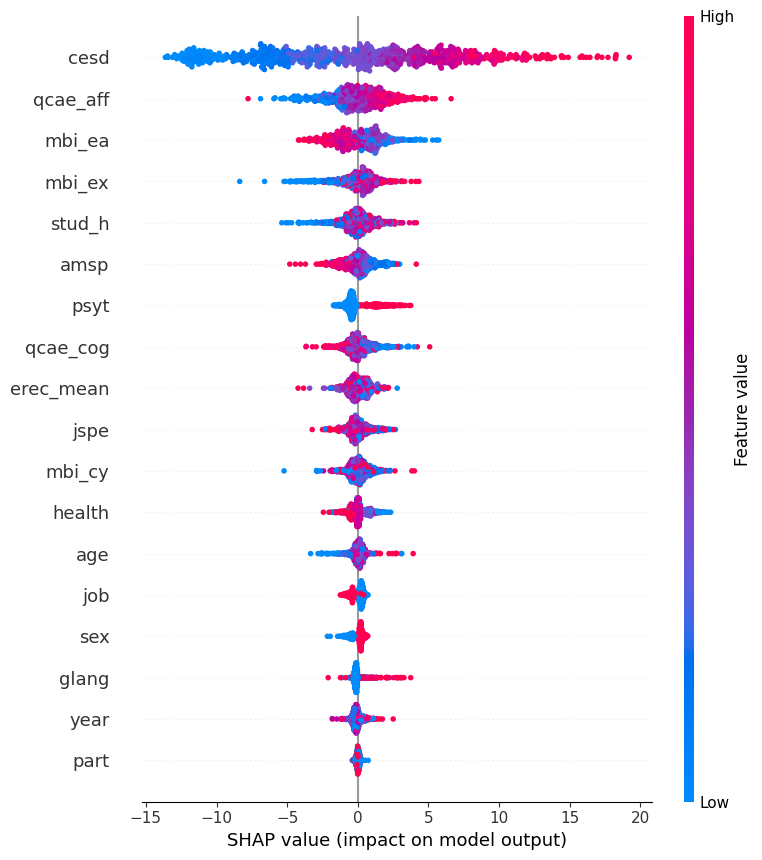

In [19]:
# For XGBoost Regressor
# Train the model on the entire training set
model_xgb_reg = XGBRegressor(learning_rate=0.1, n_estimators=300, max_depth=5, random_state=101)
scaler_reg = StandardScaler()
X_train_scaled_reg = scaler_reg.fit_transform(X_train_reg)
model_xgb_reg.fit(X_train_scaled_reg, y_train_reg)

# Create a TreeExplainer object
explainer_xgb_reg = shap.TreeExplainer(model_xgb_reg)

# Calculate SHAP values
shap_values_xgb_reg = explainer_xgb_reg.shap_values(X_train_scaled_reg)

# Summary plot of feature importance
shap.summary_plot(shap_values_xgb_reg, X_train_scaled_reg, feature_names=X_train_reg.columns)

